In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import json
import cv2
import torch
from PIL import Image
from torchvision import transforms as T

from mpl_toolkits.mplot3d import Axes3D
import tikzplotlib

/home/carlas/anaconda3/envs/TCP/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/carlas/anaconda3/envs/TCP/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [8]:
df = pd.read_csv("DS/log/DAVE2-SNGP-GPU-10/train_loss_array-3.txt", sep=" ", header=None)
cols = ["epoch","accel_loss","theta_loss","brake_loss","loss"] 
#df = df.drop(columns=[2, 3, 5, 6, 8, 9])
#df = df.drop(columns=[2, 3])
df.columns = cols
#df["steer loss"] = df["steer loss"].map(lambda x: x.lstrip("tensor(").rstrip(""))
#df["accel loss"] = df["accel loss"].map(lambda x: x.lstrip("tensor(").rstrip(""))
#df["loss"] = df["loss"].map(lambda x: x.lstrip("tensor(").rstrip(""))
#df["steer loss"] = df["steer loss"].str.replace(',', '').astype(float)
#df["accel loss"] = df["accel loss"].str.replace(',', '').astype(float)
#df["loss"] = df["loss"].str.replace(',', '').astype(float)
df["epoch"] = df["epoch"].astype(int)
#df = df.drop(columns=df.filter(like='grad_fn'))
print(df.head())

   epoch  accel_loss  theta_loss  brake_loss      loss
0      1    0.219422    0.036571    0.241726  0.497719
1      1    0.189692    0.015625    0.218690  0.424007
2      1    0.198917    0.010838    0.250252  0.460007
3      1    0.165515    0.012398    0.220348  0.398262
4      1    0.162713    0.007609    0.226270  0.396592


In [9]:
val = pd.read_csv("DS/log/DAVE2-SNGP-GPU-10/val_loss_array-3.txt", sep=" ", header=None)
cols_val = ["epoch", "loss", "test likelihood"] 
val.columns = cols_val
print(val.tail())

   epoch      loss  test likelihood
5     36  0.008960         0.402809
6     42  0.007982         0.463193
7     48  0.006895         0.428082
8     54  0.005998         0.443009
9     60  0.005270         0.417993


In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("losses")
plt.plot(df["epoch"], df["loss"], label="loss")
#plt.plot(df["epoch"], df["accel loss"], label="acceleration loss")
#plt.plot(df["epoch"], df["steer loss"], label="steering loss")
plt.xlabel("epoch")
plt.ylabel("mse loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("means")
sns.lineplot(data=df, x=df["epoch"], y=df["loss"], label="loss")
sns.lineplot(data=df, x=df["epoch"], y=df["theta_loss"], label="theta_loss")
sns.lineplot(data=df, x=df["epoch"], y=df["accel_loss"], label="accel_loss")
sns.lineplot(data=df, x=df["epoch"], y=df["brake_loss"], label="brake_loss")
sns.scatterplot(data=val, x=val["epoch"], y=val["loss"], label="loss")
sns.lineplot(data=val, x=val["epoch"], y=val["test likelihood"], label="test likelihood")
#sns.lineplot(data=df, x=df["epoch"], y=df["accel loss"], label="acceleration loss")
#sns.lineplot(data=df, x=df["epoch"], y=df["steer loss"], label="steering loss")
plt.ylabel("mse loss")


Text(0, 0.5, 'mse loss')

In [57]:
results = pd.DataFrame(columns=[
    "steer", 
    "uncertainty_steer", 
    "throttle", 
    "uncertainty_throttle", 
    "brake", 
    "position x",
    "position y",
    "compass",
    "speed"], dtype=float)
path = 'DS/data/results_DAVE2_SNGP-7/routes_town05_short_11_23_13_40_29/meta'
for _, _, files in os.walk(path):
    for file in sorted(files):
        f = open(path + "/" + file)
        r = pd.DataFrame([json.load(f)])
        results = pd.concat([results, r], ignore_index=True)
#results = results.drop(["position"], axis=1)
print(results.head(6))


      steer  uncertainty_steer  throttle  uncertainty_throttle  brake  \
0 -0.147626           0.000297  0.954378              0.000439    0.0   
1 -0.143086           0.000255  0.961777              0.000364    0.0   
2 -0.140773           0.000247  0.963603              0.000368    0.0   
3 -0.159044           0.000484  0.840048              0.000697    0.0   
4 -0.005405           0.000282  0.684350              0.000420    0.0   
5  0.035344           0.000346  0.479261              0.000211    0.0   

   position x  position y             compass                   speed  
0   -6.446770 -163.162537  1.5683622360229492   7.196098401400504e-07  
1   -6.446770 -163.162537  1.5683622360229492    3.02687285045636e-08  
2   -6.446769 -163.162537  1.5683622360229492  2.2953311988327817e-08  
3   -6.400642 -162.668244  1.5330369472503662       2.464848319122716  
4   -6.053717 -160.650986  1.3881652355194092       4.833591876581817  
5   -5.424553 -157.948868  1.3527861833572388       5.83

In [89]:
# go through evaluation folder
routes_type = "val"
towns = ["town01"]
month = "11"
day = "29"
result_pattern = "routes_{}_{}_{}_{}" # town_route_month_day 
result_path = ""
data_folder = "DS/data/results_DAVE2_SNGP-10"

meta  = pd.DataFrame()
columns = [
    'steer', 
    'uncertainty_steer', 
    'throttle', 
    'uncertainty_throttle', 
    'brake', 
    'position x', 
    'position y', 
    'compass', 
    'speed',
    'route']
for town in towns:
    sub_folders = os.listdir(data_folder)
    sub_folders = sorted(list(sub_folders))
    result_file = result_pattern.format(town, routes_type, month, day)
    valid = [] 
    for sub in sub_folders:
        if result_file in str(sub):
            valid.append(sub + "/meta")
    for v in valid:
        folder = os.path.join(data_folder, v)
        meta_files = os.listdir(folder)
        meta_files = sorted(list(meta_files))
        for m in meta_files:
            with open(os.path.join(folder, m), 'r') as f:
                records = json.load(f)
                records['route'] = v
                if meta.empty:
                    meta = pd.DataFrame(records, index=[0], columns=columns)
                else:
                    meta = meta.append(records, ignore_index=True)

#print(meta)

In [90]:
# feature maps
feature_maps = []
pics = []
cs = ['map', 'route']
for town in towns:
    sub_folders = os.listdir(data_folder)
    sub_folders = sorted(list(sub_folders))
    result_file = result_pattern.format(town, routes_type, month, day)
    valid = [] 
    rgbs = []
    for sub in sub_folders:
        if result_file in str(sub):
            valid.append(sub + "/fms")
            rgbs.append(sub + "/rgb")
    for v in valid:
        folder = os.path.join(data_folder, v)
        fms_files = os.listdir(folder)
        fms_files = sorted(list(fms_files))
        for m in fms_files:
            dic = {} 
            f = torch.load(os.path.join(folder, m)).cpu().numpy()
            dic['map'] = f
            dic['route'] = v 
            feature_maps.append(dic)
    for v in rgbs:
        folder = os.path.join(data_folder, v)
        rgb_files = os.listdir(folder)
        rgb_files = sorted(list(rgb_files))
        for m in rgb_files:
            pics.append(os.path.join(folder, m))


    

In [92]:
max_u = np.max([meta['uncertainty_steer'].max(), meta['uncertainty_throttle'].max()]) 
cmap = sns.color_palette("coolwarm", as_cmap=True)
colors = cmap(np.linspace(0, 1, 5))
vid_folder = os.path.join('vids/fms', result_file)

for f in range(len(feature_maps)):
    maps = feature_maps[f]
    onemap = maps['map'][0,0,:,:] 
    for p in range(1, 64):
        onemap += maps['map'][0,p,:,:]
    plt.figure(num=f, figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(onemap)
    plt.subplot(1, 3, 2)
    img = Image.open(pics[f])
    plt.imshow(img)

    route = os.path.join(maps['route'].split(sep="/")[0], "meta")
    single = meta.loc[meta['route']==route]
    tick = np.linspace(0, len(single.index), num=len(single.index))
    plt.subplot(1, 3, 3)
    plt.vlines(x=f, ymin=0.0, ymax=max_u, colors='k', linestyles='dashed')
    plt.plot(single.index, single['uncertainty_steer'], c=colors[0], label='variance steering')
    plt.plot(single.index, single['uncertainty_throttle'], c=colors[4], label='variance acceleration')
    plt.ylim(top=max_u, bottom=0)
    plt.grid()
    plt.legend()
    plt.ylabel("uncertainty")
    plt.xlabel("tick")
    plt.savefig(os.path.join(vid_folder, ('%04d.png' % f)))
    plt.close()
    


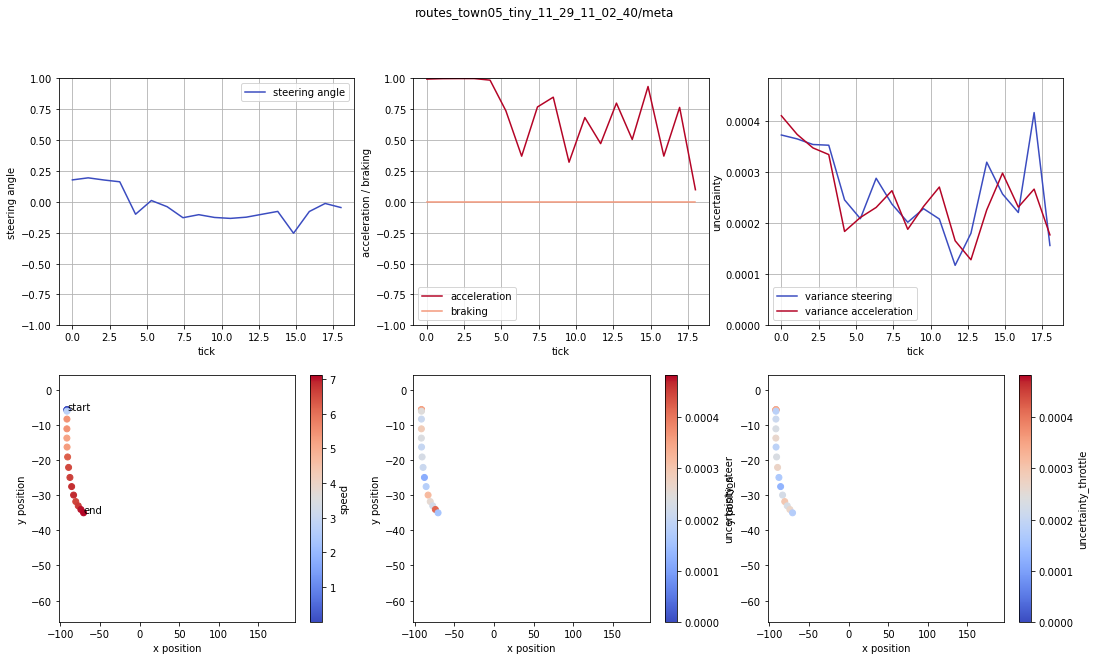

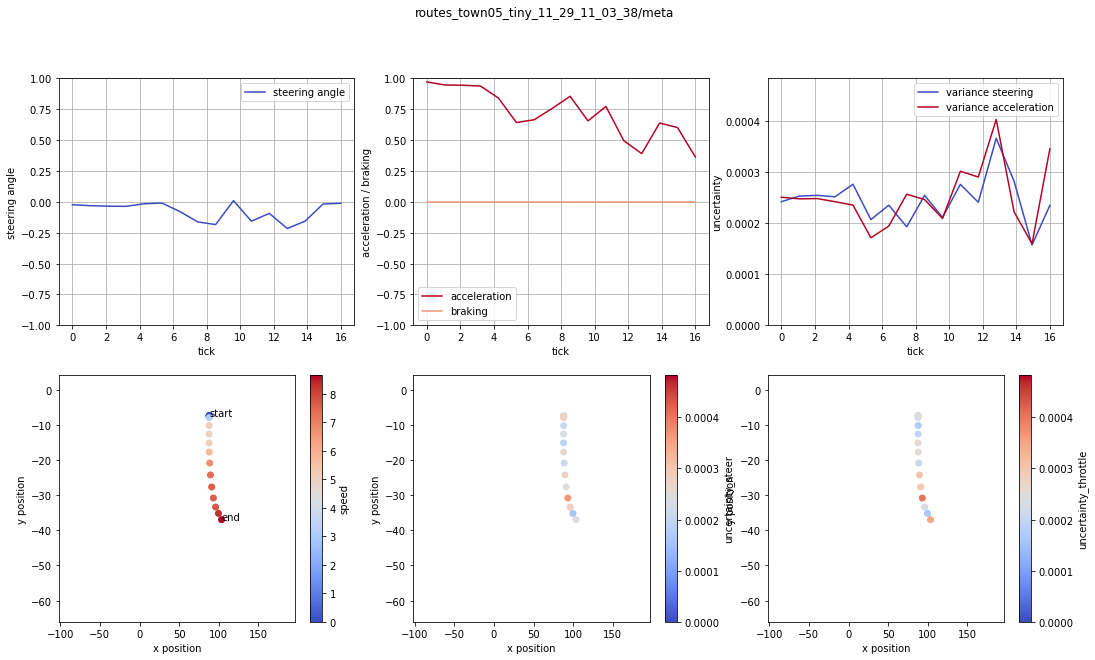

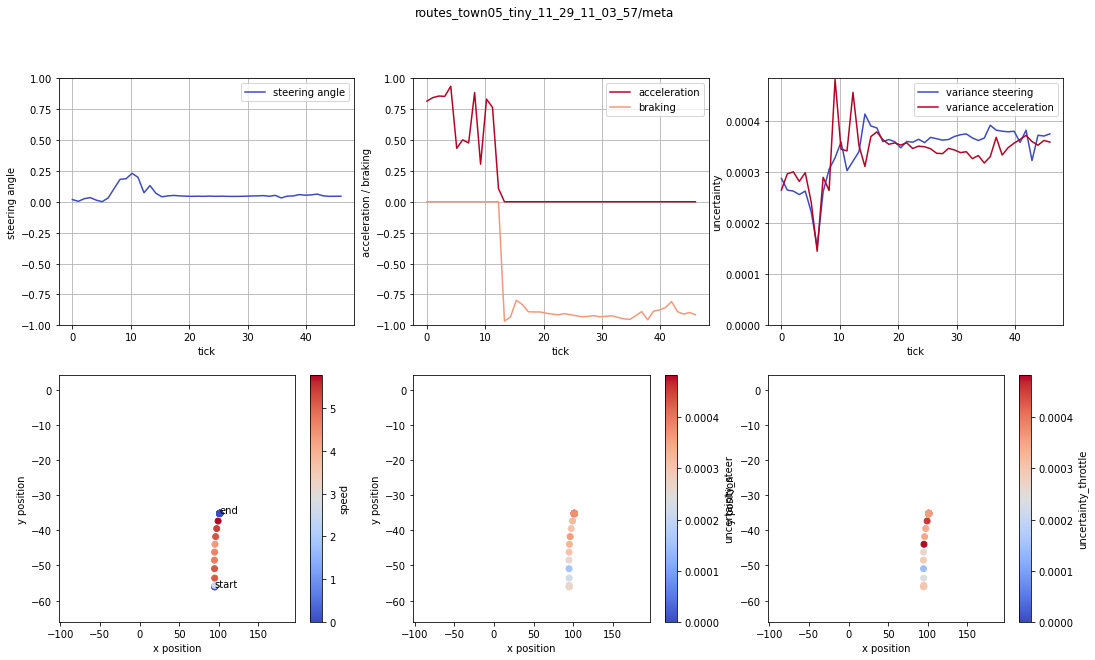

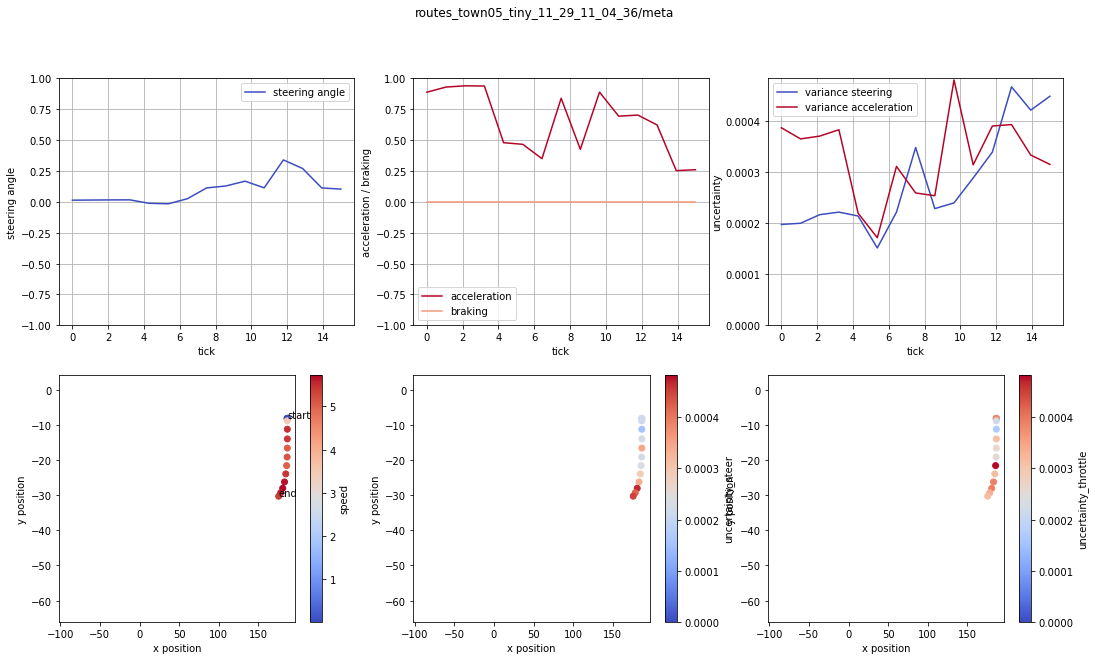

In [36]:
cmap = sns.color_palette("coolwarm", as_cmap=True)
colors = cmap(np.linspace(0, 1, 5))
max_u = np.max([meta['uncertainty_steer'].max(), meta['uncertainty_throttle'].max()]) 
max_x = meta['position x'].max()
min_x = meta['position x'].min()
max_y = meta['position y'].max()
min_y = meta['position y'].min()

for s in meta["route"].unique():
    single = meta.loc[meta['route']==s]
    tick = np.linspace(0, len(single.index), num=len(single.index))
    plt.figure(num=s, figsize=(18,10))
    plt.suptitle(s)
    plt.subplot(2, 3, 1)
    plt.plot(tick, single['steer'], c=colors[0], label='steering angle')
    plt.ylim(top=1, bottom=-1)
    plt.grid()
    plt.legend()
    plt.ylabel("steering angle")
    plt.xlabel("tick")

    plt.subplot(2, 3, 2)
    plt.plot(tick, single['throttle'], c=colors[4], label='acceleration')
    plt.plot(tick, -single['brake'], c=colors[3], label='braking')
    plt.ylim(top=1, bottom=-1)
    plt.grid()
    plt.legend()
    plt.ylabel("acceleration / braking")
    plt.xlabel("tick")

    plt.subplot(2, 3, 3)
    plt.plot(tick, single['uncertainty_steer'], c=colors[0], label='variance steering')
    plt.plot(tick, single['uncertainty_throttle'], c=colors[4], label='variance acceleration')
    plt.ylim(top=max_u, bottom=0)
    plt.grid()
    plt.legend()
    plt.ylabel("uncertainty")
    plt.xlabel("tick")

    plt.subplot(2, 3, 4)
    v = [] 
    for val in single['speed']:
        v.append(float(val))
    plt.scatter(single['position x'], -single['position y'], c=v, cmap=cmap)
    plt.annotate("start", (single['position x'][single.index[0]], -single['position y'][single.index[0]]))
    plt.annotate("end", (single['position x'][single.index[-1]], -single['position y'][single.index[-1]]))
    plt.ylim(-max_y-10, -min_y+10)
    plt.xlim(min_x-10, max_x+10)
    plt.colorbar(label="speed")
    plt.xlabel("x position")
    plt.ylabel("y position")

    plt.subplot(2, 3, 5)
    us = [] 
    for val in single['uncertainty_steer']:
        us.append(float(val))
    plt.scatter(single['position x'], -single['position y'], c=us, cmap=cmap)
    plt.ylim(-max_y-10, -min_y+10)
    plt.xlim(min_x-10, max_x+10)
    plt.colorbar(label="uncertainty_steer")
    plt.clim(0, max_u)
    plt.xlabel("x position")
    plt.ylabel("y position")

    plt.subplot(2, 3, 6)
    ut = [] 
    for val in single['uncertainty_throttle']:
        ut.append(float(val))
    plt.scatter(single['position x'], -single['position y'], c=ut, cmap=cmap)
    plt.ylim(-max_y-10, -min_y+10)
    plt.xlim(min_x-10, max_x+10)
    plt.colorbar(label="uncertainty_throttle")
    plt.clim(0, max_u)
    plt.xlabel("x position")
    plt.ylabel("y position")


Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan],
             dtype='float64')

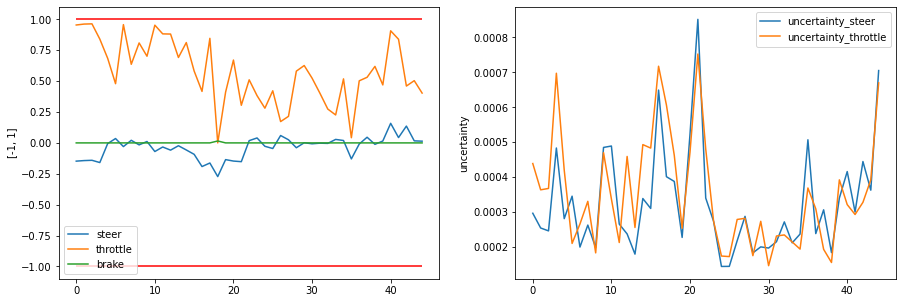

In [56]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=results, x=results.index, y=results["steer"], label="steer")
sns.lineplot(data=results, x=results.index, y=results["throttle"], label="throttle")
sns.lineplot(data=results, x=results.index, y=results["brake"], label="brake")
plt.hlines(y=[-1.0, 1.0], xmin=0.0, xmax=results.index[-1], colors=['r'])
plt.ylabel("[-1, 1]")

plt.subplot(1, 2, 2)
sns.lineplot(data=results, x=results.index, y=results["uncertainty_steer"], label="uncertainty_steer")
sns.lineplot(data=results, x=results.index, y=results["uncertainty_throttle"], label="uncertainty_throttle")
plt.ylabel("uncertainty")

# crash at (x=-157.949, y=5.424, z=0.034)
#results.index.where(results["position y"] < -157.949)

In [100]:
v = [] 
for val in results['speed']:
    v.append(float(val))
vs = [] 
for val in results['uncertainty_steer']:
    vs.append(float(val))
va = [] 
for val in results['uncertainty_throttle']:
    va.append(float(val))
i = []
for val in results.index:
    i.append(val)

cmap = sns.color_palette("rocket", as_cmap=True)

plt.figure(figsize=(8, 20))
plt.subplot(3, 1, 1)
plt.scatter(
    -results["position x"], 
    results["position y"], 
    c=v,
    cmap=cmap)
for p, txt in enumerate(i):
    plt.annotate(txt, (-results["position x"][p], results["position y"][p]), size=7)

# crash at (x=-157.949, y=5.424, z=0.034)
plt.plot(5.424, -157.949, "kx")

plt.colorbar(label="speed")
plt.xlabel("x position")
plt.ylabel("y position")

plt.subplot(3, 1, 2)
plt.scatter(
    -results["position x"], 
    results["position y"], 
    c=vs,
    cmap=cmap)
plt.colorbar(label="uncertainty steer")
plt.xlabel("x position")
plt.ylabel("y position")

plt.subplot(3, 1, 3)
plt.scatter(
    -results["position x"], 
    results["position y"], 
    c=va,
    cmap=cmap)
plt.colorbar(label="uncertainty accel")
plt.xlabel("x position")
plt.ylabel("y position")

Text(0, 0.5, 'y position')

In [16]:
# rescale ood
from PIL import Image
image = Image.open('DS/data/town05_short/routes_town05_short_01_04_12_17_28/rgb/pexels-pixabay-2150.jpg')
image_array = np.array(image)
print(image_array.shape)
resized = image_array[:256, :900, :] 
print(resized.shape)
resized = Image.fromarray(resized)
for i in range(10, 20):
    p = os.path.join('DS/data/town05_short/routes_town05_short_01_04_12_17_28/rgb', '00'+str(i)+'.png')
    resized.save(p)

(1794, 2500, 3)
(256, 900, 3)


In [23]:
cols_single = [
    "s_loss",
    "a_loss",
    "b_loss",
    "loss",
    "true_s",
    "true_a",
    "true_b",
    "pred_s",
    "pred_a",
    "pred_b",
    "var_s",
    "var_a",
    "img"]
path = 'DS/log/single-eval-10/train_loss_array.txt'
results_single = pd.read_csv(path, sep=" ", header=None)
results_single.columns = cols_single
print(results_single["fmap"].head(10))


ParserError: Error tokenizing data. C error: Expected 35 fields in line 41, saw 38


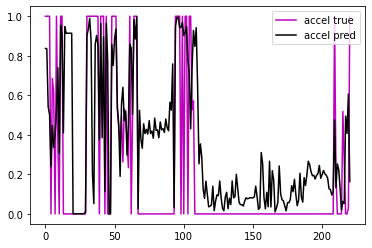

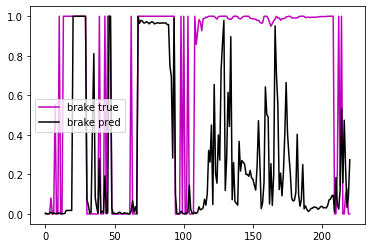

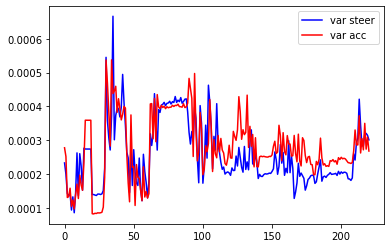

In [12]:
results_single = results_single.loc[results_single['img']=="routes_town05_short_01_04_12_17_28"]
plt.figure(1)
plt.plot(results_single.index, results_single["s_loss"], c="b", label="steer loss")
plt.plot(results_single.index, results_single["a_loss"], c="r", label="accel loss")
plt.plot(results_single.index, results_single["b_loss"], c="g", label="brake loss")
plt.legend()
plt.figure(2)
plt.plot(results_single.index, results_single["true_s"], c="m", label="steer true")
plt.plot(results_single.index, results_single["pred_s"], c="k", label="steer pred")
plt.legend()
plt.figure(3)
plt.plot(results_single.index, results_single["true_a"], c="m", label="accel true")
plt.plot(results_single.index, results_single["pred_a"], c="k", label="accel pred")
plt.legend()
plt.figure(4)
plt.plot(results_single.index, results_single["true_b"], c="m", label="brake true")
plt.plot(results_single.index, results_single["pred_b"], c="k", label="brake pred")
plt.legend()
plt.figure(5)
plt.plot(results_single.index, results_single["var_s"], c="b", label="var steer")
plt.plot(results_single.index, results_single["var_a"], c="r", label="var acc")
plt.legend()

DS-c5-095 	 0.031064221845740675 	 0.29370446221974605
DS-c5 		 0.022002872805993896 	 0.22148036183669972
DS-nospec 	 0.013459994804237839 	 0.2841736138290845
Vanilla 	 0.02651076934909303 	 0.3122663853106272


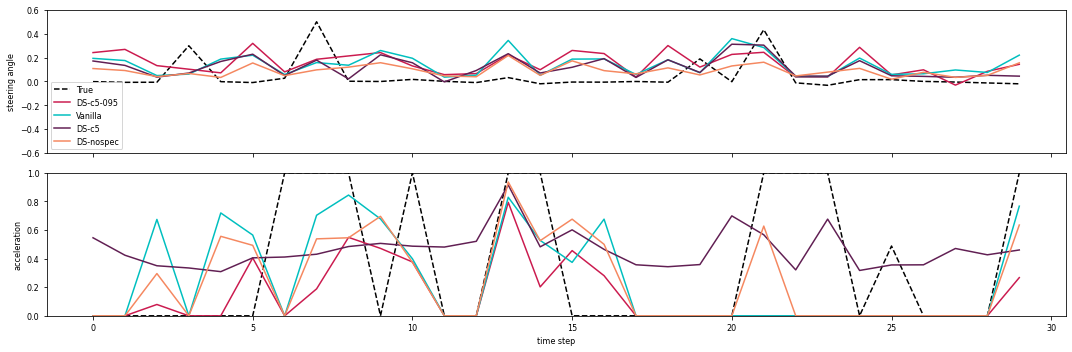

In [10]:
# full vs vanilla
cols =[
    "s_loss",
    "a_loss",
    "b_loss",
    "loss",
    "true_s",
    "true_a",
    "true_b",
    "pred_s",
    "pred_a",
    "pred_b",
    "var_s",
    "var_a",
    "img",
] 

full = pd.read_csv("DS/log/single-eval-vanilla-vs-full/train_loss_array-full.txt", sep=" ", header=None)
vanilla = pd.read_csv("DS/log/single-eval-vanilla-vs-full/train_loss_array-vanilla.txt", sep=" ", header=None)
c5 = pd.read_csv("DS/log/single-eval-vanilla-vs-full/train_loss_array-fullc5.txt", sep=" ", header=None)
nospec = pd.read_csv("DS/log/single-eval-vanilla-vs-full/train_loss_array-fullnospec.txt", sep=" ", header=None)
full.columns = cols
vanilla.columns = cols
c5.columns = cols
nospec.columns = cols

cmap = sns.color_palette("rocket", as_cmap=True)
colors = cmap(np.linspace(0, 1, 5))

plt.figure(figsize=(15,5))
ax3 = plt.subplot(2, 1, 2)
plt.plot(full.index[:30], full["true_a"][:30], "k--", label="True")
plt.plot(full.index[:30], full["pred_a"][:30], c=colors[2], label="DS-c5-095")
plt.plot(full.index[:30], vanilla["pred_a"][:30], c='c', label="Vanilla")
plt.plot(full.index[:30], c5["pred_a"][:30], c=colors[1], label="DS-c5")
plt.plot(full.index[:30], nospec["pred_a"][:30], c=colors[3], label="DS-nospec")
plt.ylabel("acceleration", fontsize=8)
plt.xlabel("time step", fontsize=8)
plt.tick_params('x', labelsize=8)
plt.tick_params('y', labelsize=8)
plt.ylim(0, 1)
#plt.legend()
plt.tight_layout()

ax1 = plt.subplot(2, 1, 1, sharex=ax3)
plt.plot(full.index[:30], full["true_s"][:30], "k--", label="True")
plt.plot(full.index[:30], full["pred_s"][:30], c=colors[2], label="DS-c5-095")
plt.plot(full.index[:30], vanilla["pred_s"][:30], c='c', label="Vanilla")
plt.plot(full.index[:30], c5["pred_s"][:30], c=colors[1], label="DS-c5")
plt.plot(full.index[:30], nospec["pred_s"][:30], c=colors[3], label="DS-nospec")
plt.ylabel("steering angle", fontsize=8)
plt.tick_params('x', labelbottom=False)
plt.tick_params('y', labelsize=8)
plt.ylim(-0.6, 0.6)
plt.legend(fontsize=8)
plt.tight_layout()

#plt.savefig("DS/log/single-eval-vanilla-vs-full/vanilla_vs_full.svg", format="svg")

print("DS-c5-095 \t", np.mean(full["s_loss"]), "\t", np.mean(full["a_loss"]))
print("DS-c5 \t\t", np.mean(c5["s_loss"]), "\t", np.mean(c5["a_loss"]))
print("DS-nospec \t", np.mean(nospec["s_loss"]), "\t", np.mean(nospec["a_loss"]))
print("Vanilla \t", np.mean(vanilla["s_loss"]), "\t", np.mean(vanilla["a_loss"]))



In [9]:
# https://stackoverflow.com/questions/21321670/how-to-change-fonts-in-matplotlib-python
from matplotlib import rc
import matplotlib as mpl
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['font.family'] = 'DeJavu Serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
rc('text', usetex=False)

Index(['name', 'label', 'throttle_mean_gp', 'throttle_mean_uncali',
       'steer_mean_gp', 'steer_mean_uncali', 'throttle_nll_gp',
       'throttle_nll_uncali', 'steer_nll_gp', 'steer_nll_uncali',
       'throttle_var_gp', 'throttle_var_uncali', 'steer_var_gp',
       'steer_var_uncali'],
      dtype='object')
NLL steering carla: 	 20.075603834454398
NLL steering nuscenes: 	 3.072033187386399
NLL throttle carla: 	 195.48696367961452
NLL throttle nuscenes: 	 59.50117350688192


/home/carlas/anaconda3/envs/TCP/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


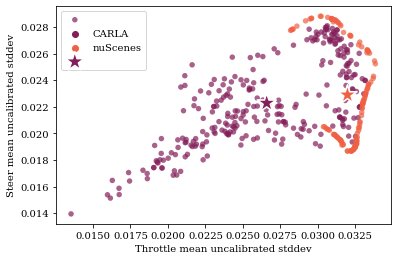

In [20]:
# scatter plots to compare domain awareness
#full = pd.read_csv("DS/calibration/DS-c5-095.csv", sep=",", header=0)
#noSing = pd.read_csv("DS/calibration/DS-c5-095_noSing.csv", sep=",", header=0)
#noSing = pd.read_csv("DS/calibration/DS-c5-095_noSing_norm.csv", sep=",", header=0)
#c5 = pd.read_csv("DS/calibration/DS-c5.csv", sep=",", header=0)
#nospec = pd.read_csv("DS/calibration/DS-nospec.csv", sep=",", header=0)
noNorm = pd.read_csv("DS/calibration/DS-c5-095_noNorm.csv", sep=",", header=0)
noNormx2 = pd.read_csv("DS/calibration/DS-c5-095_noNorm_noNorm.csv", sep=",", header=0)
noSing = noNorm
print(noSing.columns)

l = ["carla", "nuscenes"]
plt.figure("means of recalibrated stddevs")
#plt.suptitle("means of recalibrated stddevs")
#sns.scatterplot(data=noSing, x="throttle_mean_gp", y="steer_mean_gp", hue="label", palette="rocket", s=30, alpha=0.7, linewidth=0)
sns.scatterplot(data=noSing, x="throttle_mean_uncali", y="steer_mean_uncali", hue="label", palette="rocket", s=30, alpha=0.7, linewidth=0)
#centroids = np.hstack([np.vstack([noSing[noSing["label"] == name][dir].mean()]for name in l) for dir in ["throttle_mean_gp", "steer_mean_gp"]])
centroids = np.hstack([np.vstack([noSing[noSing["label"] == name][dir].mean()]for name in l) for dir in ["throttle_mean_uncali", "steer_mean_uncali"]])
centroids = pd.DataFrame(centroids, columns=["x", "y"])
centroids["label"] = l
sns.scatterplot(data=centroids, x="x", y="y", hue="label", palette="rocket", s=400, marker="*")
plt.xlabel("Throttle mean uncalibrated stddev")
#plt.xlabel("Throttle mean recalibrated stddev")
plt.ylabel("Steer mean uncalibrated stddev")
#plt.ylabel("Steer mean recalibrated stddev")
plt.legend([None, "CARLA", "nuScenes", None])
#tikzplotlib.save("/home/carlas/Experiments/E2EDriving/UQ-E2E-AD/Thesis/pictures/means_wNorm_cali.tex")
#print(centroids)
#plt.savefig("/home/carlas/Experiments/E2EDriving/UQ-E2E-AD/Thesis/pictures/means_wNorm.svg", format="svg")

#plt.figure("variance of recalibrated stddevs")
#plt.suptitle("variance of recalibrated stddevs")
#sns.scatterplot(data=noSing, x="throttle_var_gp", y="steer_var_gp", hue="label", palette="rocket", s=50, alpha=0.8)
#centroids = np.hstack([np.vstack([noSing[noSing["label"] == name][dir].mean()]for name in l) for dir in ["throttle_var_gp", "steer_var_gp"]])
#centroids = pd.DataFrame(centroids, columns=["x", "y"])
#centroids["label"] = l
#sns.scatterplot(data=centroids, x="x", y="y", hue="label", palette="rocket", s=400, marker="*")
#plt.savefig("/home/carlas/Experiments/E2EDriving/UQ-E2E-AD/Thesis/pictures/vars_wNorm_cali.png")
#tikzplotlib.save("/home/carlas/Experiments/E2EDriving/UQ-E2E-AD/Thesis/pictures/vars_wNorm_cali.tex")

# TODO: schwerpunkt der cluster angeben
# https://stackoverflow.com/questions/62642878/how-to-plot-the-clusters-centroids-using-seaborn

#print(centroids)
#plt.figure()
#sns.pairplot(noSing, hue="label", palette="rocket")
#print(noSing.tail(), noSing.head())

print("NLL steering carla: \t", np.mean(noSing[noSing["label"] == "carla"]["steer_nll_uncali"]))
print("NLL steering nuscenes: \t", np.mean(noSing[noSing["label"] == "nuscenes"]["steer_nll_uncali"]))
print("NLL throttle carla: \t", np.mean(noSing[noSing["label"] == "carla"]["throttle_nll_uncali"]))
print("NLL throttle nuscenes: \t", np.mean(noSing[noSing["label"] == "nuscenes"]["throttle_nll_uncali"]))




2e-08


<AxesSubplot:xlabel='var', ylabel='Count'>

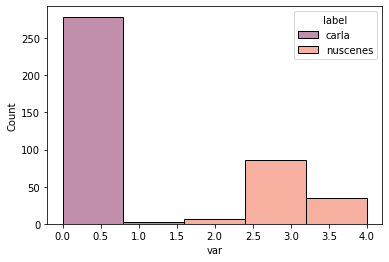

In [310]:

v = np.zeros_like(noSing["steer_mean_gp"])
border = 0.0000001*0.2
print(border)
for i in range(noSing.index.stop):
    if noSing["throttle_var_uncali"][i] < border:
        v[i] += 1
    if noSing["steer_var_uncali"][i] < border:
        v[i] += 1  
    if noSing["throttle_var_gp"][i] < border:
        v[i] += 1
    if noSing["steer_var_gp"][i] < border:
        v[i] += 1
    if noSing["label"][i] == "carla" and v[i] >= 2:
    #if noSing["label"][i] == "nuscenes" and v[i] == 0:
        print(i, v[i], noSing["name"][i])
        print(noSing["throttle_var_gp"][i], noSing["steer_var_gp"][i])

noSing["var"] = v

sns.histplot(noSing, x="var", bins=5, hue="label", palette="rocket")

Index(['comma', 'speed', 'steer', 'accel', 'brake', 'label'], dtype='object')


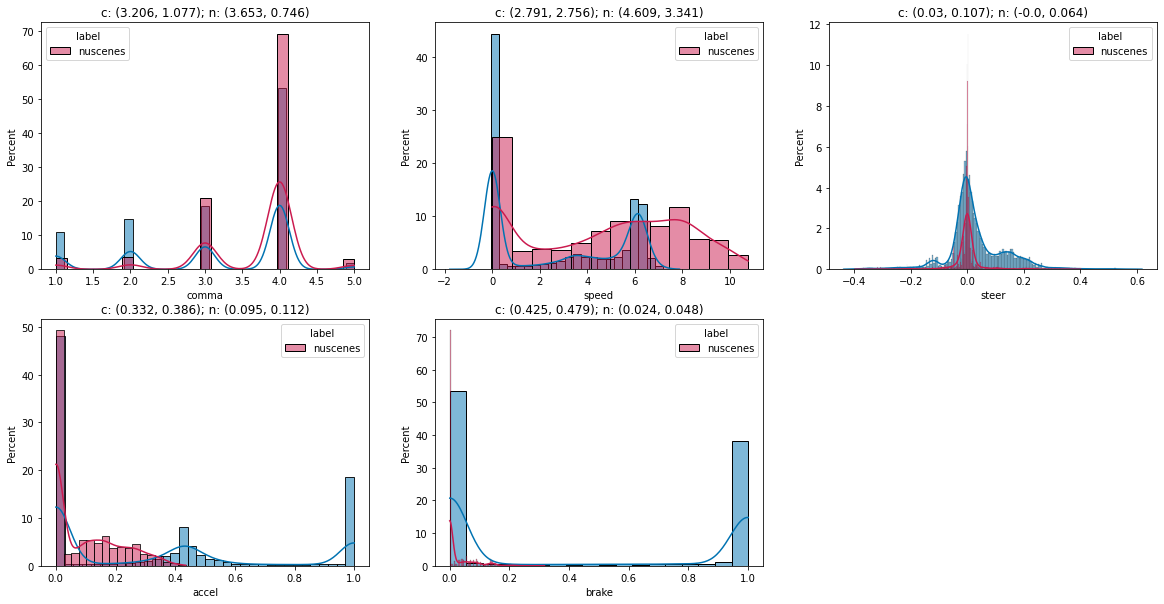

In [ ]:
#check if datasets are similar
c = pd.read_csv("DS/calibration/c_scenario_dist_noNorm.csv", sep=",", header=0)
n = pd.read_csv("DS/calibration/n_scenario_dist_noNorm.csv", sep=",", header=0)

c['label'] = ["carla"]*c.index.stop
n['label'] = ["nuscenes"]*n.index.stop

both = pd.concat([c, n], axis=0)

print(both.columns)
plot = 1
plt.figure(figsize=(20, 10))
for value in both.columns:
    if value != "label":
        plt.subplot(2, 3, plot)
        plt.title(f"c: ({round(c[value].mean(), 3)}, {round(c[value].std(), 3)}); n: ({round(n[value].mean(), 3)}, {round(n[value].std(), 3)})")
        sns.histplot(c, x=value, stat="percent", palette="colorblind", hue="label", kde=True)
        sns.histplot(n, x=value, stat="percent", palette="rocket", hue="label", kde=True)
        plot += 1

#print("carla: \n", c.mean(), c.std())
#print("nuscenes: \n", n.mean(), n.std())

#plt.figure(figsize=(20, 20))
#sns.pairplot(both, kind="kde", hue="label", palette="rocket")

In [313]:
# image normalization
img_mean = torch.load("DS/calibration/carla_img_mean.pt")
img_std = torch.load("DS/calibration/carla_img_std.pt")

img_mean = img_mean.cpu().numpy()
img_std = img_std.cpu().numpy()

print(img_mean)
print(img_std)

#plt.figure("mean and std", figsize=(20,10))
#for i in range(3):
    #map = img_mean[i, :, :]
    #plt.subplot(3, 2, 2*i+1)
    #plt.title(f"mean ch{i+1},{np.min(map)}, {np.max(map)}")
    #plt.imshow(map)
    #map = img_std[i, :, :]
    #plt.subplot(3, 2, 2*i+2)
    #plt.title(f"std ch{i+1},{np.min(map)}, {np.max(map)}")
    #plt.imshow(map)

[ 80.69004  89.79613 171.0314 ]
[56.89773 69.0447  50.1654 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

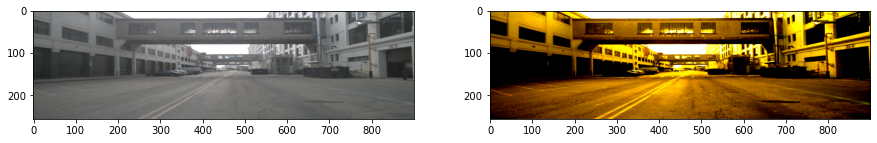

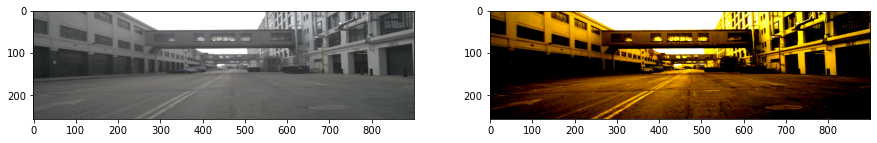

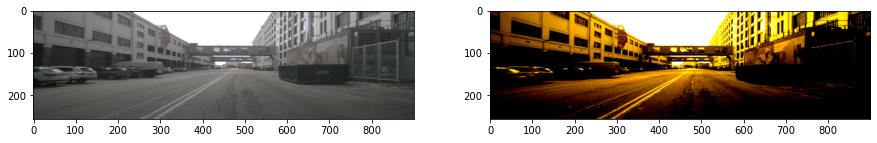

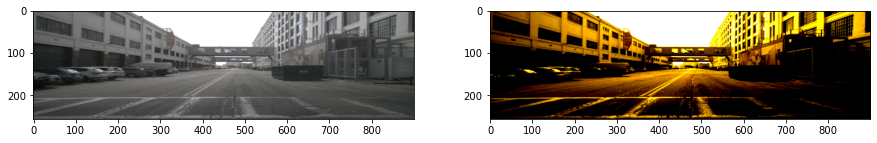

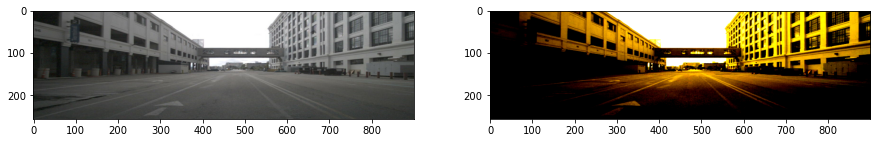

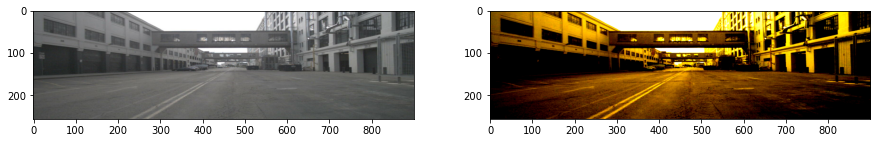

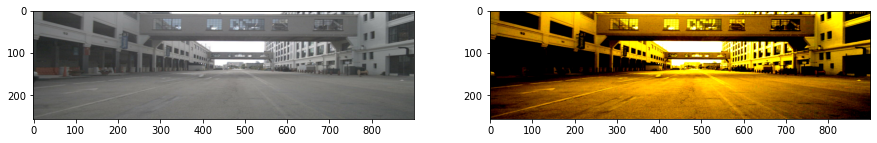

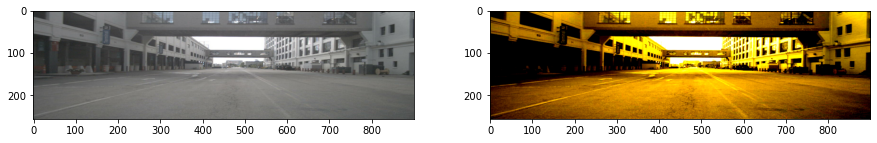

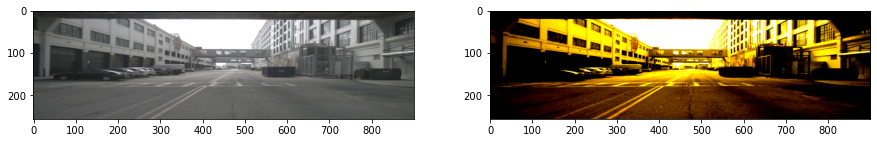

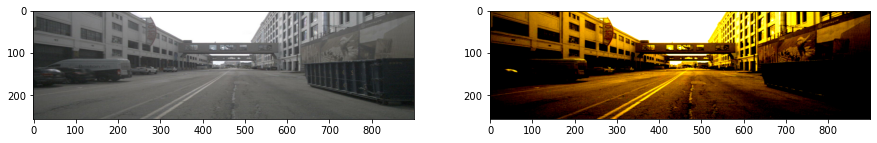

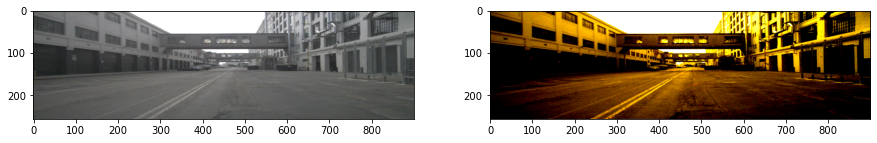

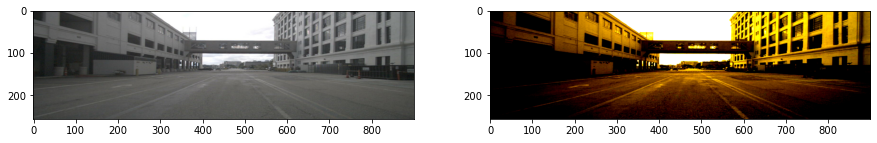

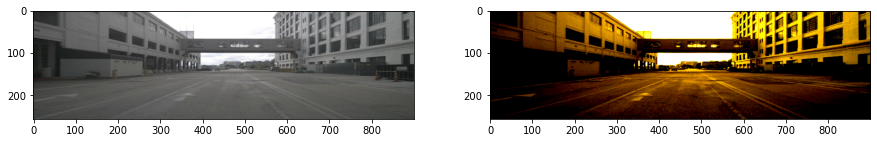

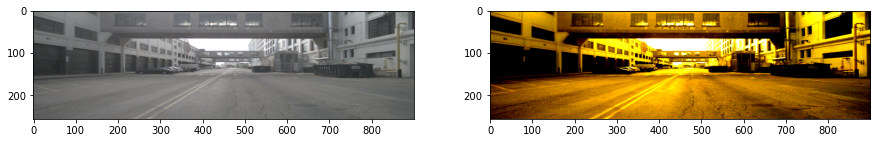

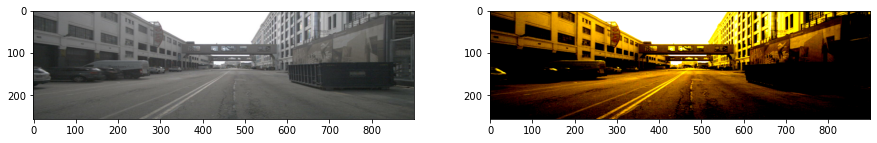

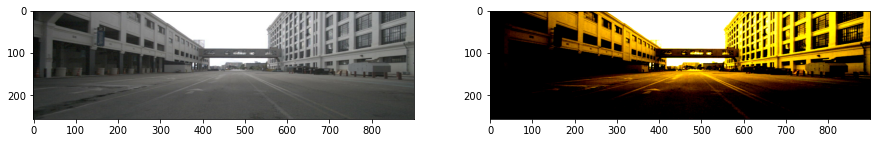

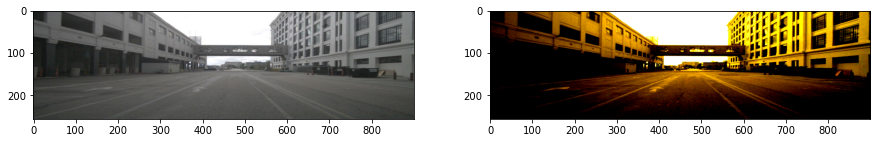

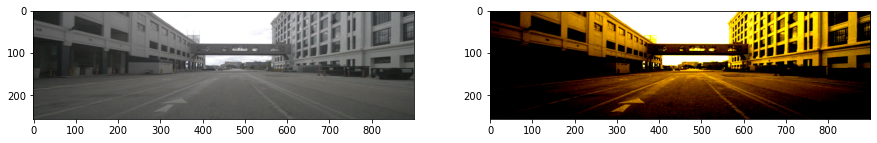

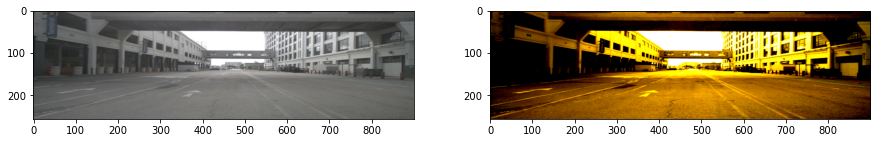

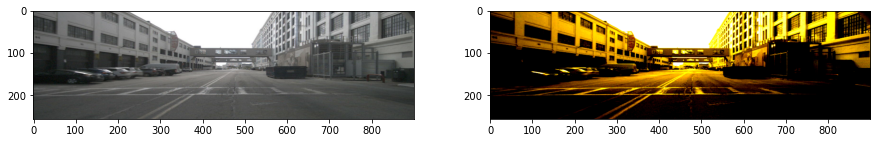

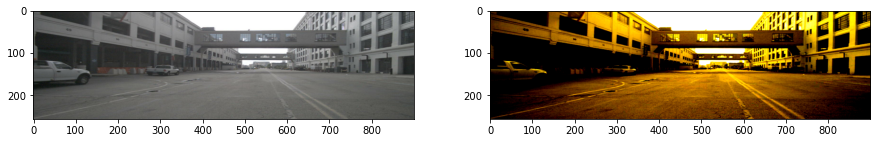

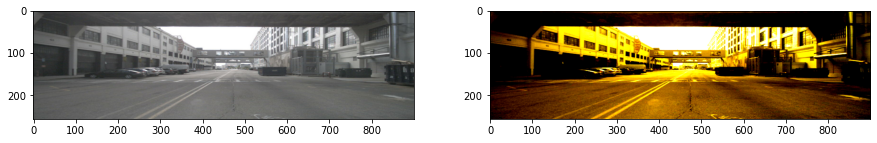

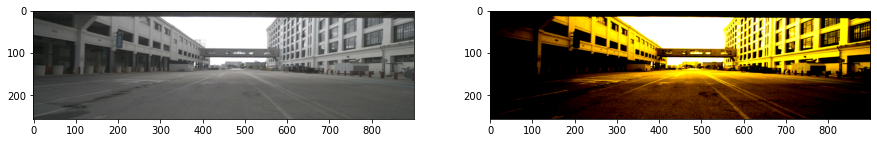

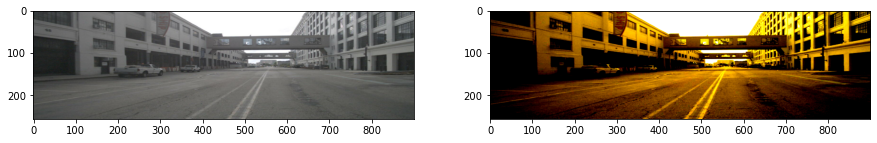

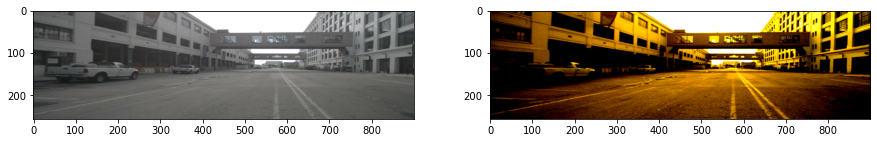

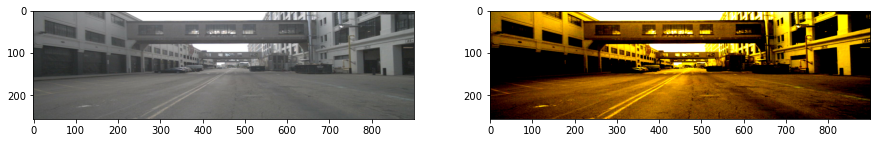

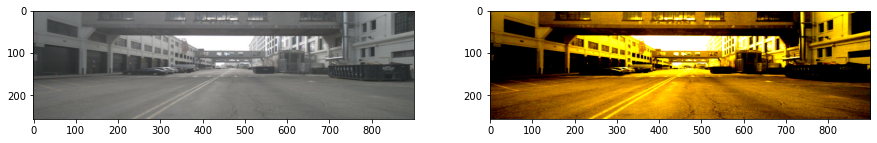

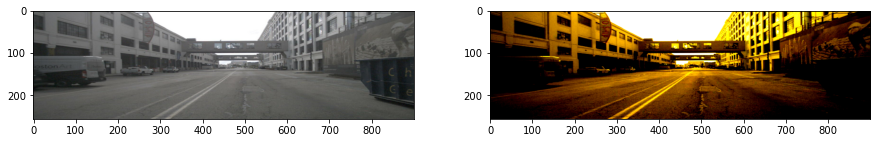

In [316]:
source = "/home/carlas/Experiments/NuScenesE2E/boston-seaport/day/scene-0062/rgb/"

for _, _, pic in os.walk(source):
    for i in pic:
        if i.endswith('.jpg'):
            image = Image.open(source + '/' + i)
            resized = image.resize((900, 256))
            resized = np.array(resized).reshape((256, 900, 3))
            
            plt.figure(i, figsize=(15, 10))
            plt.subplot(1, 2, 1)
            plt.imshow(resized)
            plt.subplot(1, 2, 2)
            #resized = resized / 255
            m = img_mean
            s = img_std
            norm = ((resized-m)/s)
            plt.imshow(norm)

In [23]:
# calibration plot
import netcal
from netcal.metrics import NLL, PinballLoss, QCE
from netcal.presentation import ReliabilityRegression
from netcal.regression import VarianceScaling, GPNormal

In [31]:
plot_c = pd.read_csv("DS/calibration/plot_calibration_c.csv", sep=",", header=0)
plot_n = pd.read_csv("DS/calibration/plot_calibration_n.csv", sep=",", header=0)
print(plot_c.columns)

Index(['plot_c_gt_steer', 'plot_c_gt_throttle', 'plot_c_mean_steer',
       'plot_c_mean_throttle', 'plot_c_std_uncali_steer',
       'plot_c_std_uncali_throttle', 'plot_c_std_recali_steer',
       'plot_c_std_recali_throttle', 'plot_c_loss_steer',
       'plot_c_loss_throttle'],
      dtype='object')


In [39]:
nll = NLL()
sc = nll.measure((np.array(plot_c["plot_c_mean_steer"]), np.array(plot_c["plot_c_std_recali_steer"])), np.array(plot_c["plot_c_gt_steer"]), reduction='mean')
sn = nll.measure((np.array(plot_n["plot_n_mean_steer"]), np.array(plot_n["plot_n_std_recali_steer"])), np.array(plot_n["plot_n_gt_steer"]), reduction='mean')
tc = nll.measure((np.array(plot_c["plot_c_mean_throttle"]), np.array(plot_c["plot_c_std_recali_throttle"])), np.array(plot_c["plot_c_gt_throttle"]), reduction='mean')
tn = nll.measure((np.array(plot_n["plot_n_mean_throttle"]), np.array(plot_n["plot_n_std_recali_throttle"])), np.array(plot_n["plot_n_gt_throttle"]), reduction='mean')


print("NLL steering carla: \t", np.mean(sc), np.std(sc))
print("NLL steering nuscenes: \t", np.mean(sn), np.std(sn))
print("NLL throttle carla: \t", np.mean(tc), np.std(tc))
print("NLL throttle nuscenes: \t", np.mean(tn), np.std(tn))
print("---------------")

sc = nll.measure((np.array(plot_c["plot_c_mean_steer"]), np.array(plot_c["plot_c_std_uncali_steer"])), np.array(plot_c["plot_c_gt_steer"]), reduction='mean')
sn = nll.measure((np.array(plot_n["plot_n_mean_steer"]), np.array(plot_n["plot_n_std_uncali_steer"])), np.array(plot_n["plot_n_gt_steer"]), reduction='mean')
tc = nll.measure((np.array(plot_c["plot_c_mean_throttle"]), np.array(plot_c["plot_c_std_uncali_throttle"])), np.array(plot_c["plot_c_gt_throttle"]), reduction='mean')
tn = nll.measure((np.array(plot_n["plot_n_mean_throttle"]), np.array(plot_n["plot_n_std_uncali_throttle"])), np.array(plot_n["plot_n_gt_throttle"]), reduction='mean')


print("NLL unc steering carla: \t", np.mean(sc), np.std(sc))
print("NLL unc steering nuscenes: \t", np.mean(sn), np.std(sn))
print("NLL unc throttle carla: \t", np.mean(tc), np.std(tc))
print("NLL unc throttle nuscenes: \t", np.mean(tn), np.std(tn))
print("---------------")
print("Mean steering uncertainty carla: \t", plot_c["plot_c_std_recali_steer"].mean())
print("Mean steering uncertainty nuscenes: \t", plot_n["plot_n_std_recali_steer"].mean())
print("Mean throttle uncertainty carla: \t", plot_c["plot_c_std_recali_throttle"].mean())
print("Mean throttle uncertainty nuscenes: \t", plot_n["plot_n_std_recali_throttle"].mean())
print("---------------")
print("std steering uncertainty carla: \t", plot_c["plot_c_std_recali_steer"].std())
print("std steering uncertainty nuscenes: \t", plot_n["plot_n_std_recali_steer"].std())
print("std throttle uncertainty carla: \t", plot_c["plot_c_std_recali_throttle"].std())
print("std throttle uncertainty nuscenes: \t", plot_n["plot_n_std_recali_throttle"].std())
print("---------------")
print("Mean steering mse carla: \t", plot_c["plot_c_loss_steer"].mean())
print("Mean steering mse nuscenes: \t", plot_n["plot_n_loss_steer"].mean())
print("Mean throttle mse carla: \t", plot_c["plot_c_loss_throttle"].mean())
print("Mean throttle mse nuscenes: \t", plot_n["plot_n_loss_throttle"].mean())
print("---------------")
print("std steering mse carla: \t", plot_c["plot_c_loss_steer"].std())
print("std steering mse nuscenes: \t", plot_n["plot_n_loss_steer"].std())
print("std throttle mse carla: \t", plot_c["plot_c_loss_throttle"].std())
print("std throttle mse nuscenes: \t", plot_n["plot_n_loss_throttle"].std())

NLL steering carla: 	 -0.4876952500414552 0.0
NLL steering nuscenes: 	 -0.7069497499091162 0.0
NLL throttle carla: 	 0.8899108761632774 0.0
NLL throttle nuscenes: 	 0.6734688840552279 0.0
---------------
NLL unc steering carla: 	 17.609989112885366 0.0
NLL unc steering nuscenes: 	 2.9868041215834484 0.0
NLL unc throttle carla: 	 202.7383881328956 0.0
NLL unc throttle nuscenes: 	 56.359876162247886 0.0
---------------
Mean steering uncertainty carla: 	 0.1837831553123183
Mean steering uncertainty nuscenes: 	 0.1817235252330693
Mean throttle uncertainty carla: 	 0.7224393041713286
Mean throttle uncertainty nuscenes: 	 0.7489667175593673
---------------
std steering uncertainty carla: 	 0.02938504439204596
std steering uncertainty nuscenes: 	 0.02649503049122232
std throttle uncertainty carla: 	 0.1990395217327866
std throttle uncertainty nuscenes: 	 0.19963548113051338
---------------
Mean steering mse carla: 	 0.02016840635492984
Mean steering mse nuscenes: 	 0.005693453355625962
Mean t

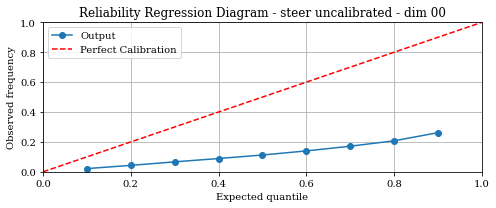

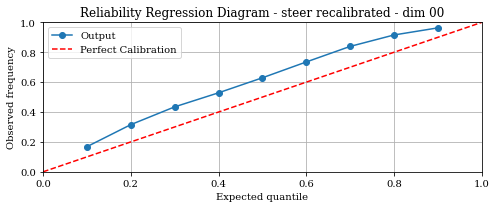

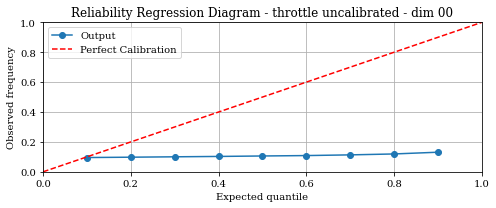

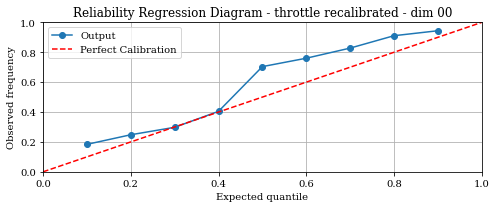

In [33]:
#carla
quantiles = np.linspace(0.1, 0.9, 9)
diagram = ReliabilityRegression(quantiles=quantiles)
diagram.plot((plot_c["plot_c_mean_steer"], plot_c["plot_c_std_uncali_steer"]), plot_c["plot_c_gt_steer"], title_suffix="steer uncalibrated")#, tikz=True, filename="/home/carlas/Experiments/E2EDriving/UQ-E2E-AD/Thesis/pictures/plot_c_steer_uncali.tex")
diagram.plot((plot_c["plot_c_mean_steer"], plot_c["plot_c_std_recali_steer"]), plot_c["plot_c_gt_steer"], title_suffix="steer recalibrated")#, tikz=True, filename="/home/carlas/Experiments/E2EDriving/UQ-E2E-AD/Thesis/pictures/plot_c_steer_recali.tex")
diagram.plot((plot_c["plot_c_mean_throttle"], plot_c["plot_c_std_uncali_throttle"]), plot_c["plot_c_gt_throttle"], title_suffix="throttle uncalibrated")#, tikz=True, filename="/home/carlas/Experiments/E2EDriving/UQ-E2E-AD/Thesis/pictures/plot_c_throttle_uncali.tex")
diagram.plot((plot_c["plot_c_mean_throttle"], plot_c["plot_c_std_recali_throttle"]), plot_c["plot_c_gt_throttle"], title_suffix="throttle recalibrated")#, tikz=True, filename="/home/carlas/Experiments/E2EDriving/UQ-E2E-AD/Thesis/pictures/plot_c_throttle_recali.tex")


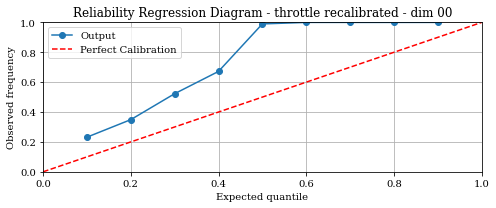

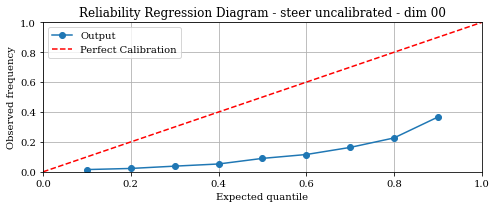

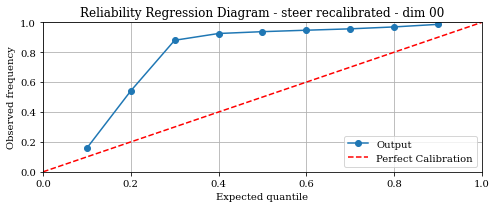

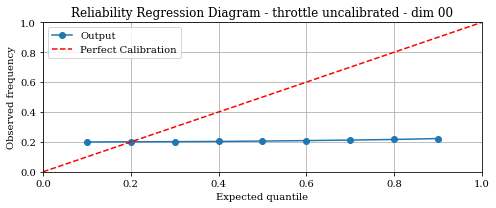

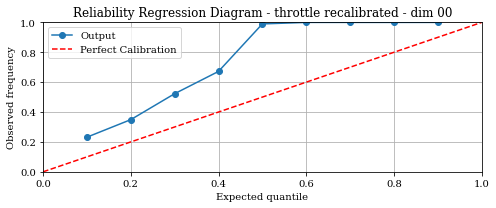

In [34]:
#nuscenes
quantiles = np.linspace(0.1, 0.9, 9)
diagram = ReliabilityRegression(quantiles=quantiles)
diagram.plot((plot_n["plot_n_mean_steer"], plot_n["plot_n_std_uncali_steer"]), plot_n["plot_n_gt_steer"], title_suffix="steer uncalibrated")#, tikz=True, filename="/home/carlas/Experiments/E2EDriving/UQ-E2E-AD/Thesis/pictures/plot_n_steer_uncali.tex")
diagram.plot((plot_n["plot_n_mean_steer"], plot_n["plot_n_std_recali_steer"]), plot_n["plot_n_gt_steer"], title_suffix="steer recalibrated")#, tikz=True, filename="/home/carlas/Experiments/E2EDriving/UQ-E2E-AD/Thesis/pictures/plot_n_steer_recali.tex")
diagram.plot((plot_n["plot_n_mean_throttle"], plot_n["plot_n_std_uncali_throttle"]), plot_n["plot_n_gt_throttle"], title_suffix="throttle uncalibrated")#, tikz=True, filename="/home/carlas/Experiments/E2EDriving/UQ-E2E-AD/Thesis/pictures/plot_n_throttle_uncali.tex")
diagram.plot((plot_n["plot_n_mean_throttle"], plot_n["plot_n_std_recali_throttle"]), plot_n["plot_n_gt_throttle"], title_suffix="throttle recalibrated")#, tikz=True, filename="/home/carlas/Experiments/E2EDriving/UQ-E2E-AD/Thesis/pictures/plot_n_throttle_recali.tex")
